# Setup

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


# Define dataset

In [3]:
with open('files_remove_indices/small_data_remove_list_indexes.npy', 'rb') as f:
    remove_list = np.load(f)

In [4]:


from torch.utils.data import Dataset, DataLoader
import glob
import rasterio
class SwedishDataset(Dataset):
    def __init__(self,  transform  = None, remove_list = None):
        self.imgs_path = "SwedenData/100tiles/"
        file_list_dem1 = sorted(glob.glob(self.imgs_path + 'dem/'+ "*/*"))
        file_list_sat1 = sorted(glob.glob(self.imgs_path + 'sat/'+ "*/*"))

        self.data = []
        for img_path_dem,img_path_sat in zip(file_list_dem1,file_list_sat1):
          self.data.append([img_path_dem,img_path_sat])

        self.transform = transform
        #self.dems1_list = file_list_dem1 
        #self.sat1_list = file_list_sat1
        if remove_list is not None:
            self.data = np.array(self.data)
            mask = np.ones(len(self.data), dtype=bool)
            mask[remove_list] = False
            self.data = self.data[mask]

        
    def __len__(self):
        return len(self.data)


    def convert_to_classes(self, temp_tensor):
          mask_tensor_1 = (temp_tensor == 111)|(temp_tensor == 112)|(temp_tensor == 113)|(temp_tensor == 114)|(temp_tensor== 115)|(temp_tensor == 116)|(temp_tensor == 117) 
          mask_tensor_2 = (temp_tensor == 118)
          mask_tensor_3 = (temp_tensor == 121)|(temp_tensor == 122)|(temp_tensor == 123)|(temp_tensor== 124)|(temp_tensor == 125)|(temp_tensor == 126)|(temp_tensor == 127)
          mask_tensor_4 = (temp_tensor == 128)
          mask_tensor_5 = (temp_tensor == 2)
          mask_tensor_6 = (temp_tensor == 3)
          mask_tensor_7 = (temp_tensor == 41)|(temp_tensor== 42)
          mask_tensor_8 = (temp_tensor == 51)|(temp_tensor == 52)|(temp_tensor == 53)
          mask_tensor_9 = (temp_tensor == 61)|(temp_tensor == 62)
          mask_tensor_outside = (temp_tensor==0)
          mask_tensors = [mask_tensor_1,mask_tensor_2,mask_tensor_3,mask_tensor_4,
                          mask_tensor_5,mask_tensor_6, mask_tensor_7,mask_tensor_8,
                          mask_tensor_9, mask_tensor_outside]
          temp_image = temp_tensor
          for i in range(10):
            temp_image = torch.where(mask_tensors[i], torch.tensor(i), temp_image)
          return temp_image
    
          
    def __getitem__(self, idx):
        img_path_dem, img_path_sat = self.data[idx]
        img_raster_dem = rasterio.open(img_path_dem).read()#[:,:96,:96]
        img_raster_sat = rasterio.open(img_path_sat).read()#[:,:170,:350]
        img_raster_sat = self.convert_to_classes(torch.from_numpy(img_raster_sat))
        
        if img_raster_dem[0].shape!=(100,100):
            if img_raster_dem[0][0,0]==0:
                img_raster_dem = img_raster_dem[:,1:,:]
            else:
                img_raster_dem = img_raster_dem[:,:-1,:]
        
        if self.transform:
          img_raster_dem = self.transform(torch.tensor(img_raster_dem))
        
        test = img_raster_sat
        outside_class = 9
        if torch.equal(test[0][0,:], torch.ones(len(test[0][0,:]))*outside_class):
            test = test[:,1:,:]
        if torch.equal(test[0][-1,:], torch.ones(len(test[0][-1,:]))*outside_class):
            test = test[:,:-1,:]
        if torch.equal(test[0][:,0], torch.ones(len(test[0][:,0]))*outside_class):
            test = test[:,:,1:]
        if torch.equal(test[0][:,-1], torch.ones(len(test[0][:,-1]))*outside_class):
            test = test[:,:,:-1]
        img_raster_sat = test
        img_raster_sat = mask_resize(img_raster_sat)
        
        return [img_raster_dem ,img_raster_sat[0].type(torch.LongTensor)]
    
    
    
    
    
def normalize_input_for_dem(test_iter):
    #test_iter = torch.from_numpy(test_iter)
    input_images = test_iter.float()
    maxv = 822
    minv = -37
    #batch_size = input_images.shape[0]
    #cmin = torch.amin(input_images,(1,2)).reshape((batch_size,1,1))
    #cmax = torch.amax(input_images,(1,2)).reshape((batch_size,1,1))
    return (input_images-minv)/(maxv-minv) #(input_images-cmin)/(cmax-cmin)

class Normalize_range01:
    #bring to range 0 to 1

    def __init__(self, p=1):
        self.p = 1

    def __call__(self, x):
        result = normalize_input_for_dem(x)
        return result

    def __repr__(self):
        return "custom augmentation"

img_size = (96,96)
mask_resize = transforms.Resize(size = img_size, interpolation=Image.NEAREST)
#dem_resize = transforms.Resize(size = img_size)
data_transforms = transforms.Compose([#transforms.ToTensor(),
                                          transforms.Resize(size = img_size),
                                          Normalize_range01(),
                                          #transforms.ToPILImage(), 
                                          #transforms.RandomHorizontalFlip(),
                                          #transforms.RandomResizedCrop(size=100),
                                          #transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
                                          #transforms.RandomGrayscale(p=0.2),
                                          #transforms.GaussianBlur(kernel_size=9),
                                          #transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

from torch.utils.data import random_split
import math
dataset = SwedishDataset(transform = data_transforms, remove_list = remove_list)

with open('files_remove_indices/train_set_indexes.npy', 'rb') as f:
    train_set_indexes = np.load(f)

with open('files_remove_indices/test_set_indexes.npy', 'rb') as f:
    test_set_indexes = np.load(f)


train_dataset = torch.utils.data.Subset(dataset, train_set_indexes)
test_dataset = torch.utils.data.Subset(dataset, test_set_indexes)
print(len(train_dataset))
print(len(test_dataset))

print(dataset[4][0].shape)
dataset[4]


1943
344
torch.Size([1, 96, 96])


/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[tensor([[[-0.1199, -0.1199, -0.1222,  ..., -0.1572, -0.1572, -0.1595],
          [-0.1222, -0.1246, -0.1246,  ..., -0.1572, -0.1595, -0.1595],
          [-0.1222, -0.1246, -0.1246,  ..., -0.1572, -0.1595, -0.1595],
          ...,
          [-0.0477, -0.0454, -0.0431,  ..., -0.1618, -0.1641, -0.1618],
          [-0.0384, -0.0361, -0.0314,  ..., -0.1618, -0.1641, -0.1618],
          [-0.0314, -0.0291, -0.0244,  ..., -0.1618, -0.1618, -0.1641]]]),
 tensor([[0, 0, 0,  ..., 8, 8, 8],
         [0, 0, 0,  ..., 8, 8, 8],
         [0, 6, 0,  ..., 8, 8, 8],
         ...,
         [0, 0, 0,  ..., 8, 8, 8],
         [0, 0, 0,  ..., 8, 8, 8],
         [0, 0, 0,  ..., 8, 8, 8]])]

# Saving images as png or tif

In [ ]:
#tif
count = 0
for dem, lbl in dataset:
    
    Image.fromarray(dem[0].numpy().astype(np.float32)).save('/home/azamat.kaibaldiyev/mmsegmentation/SwedenDataset/images/img' +str(count)+'.tif')                                                   
    #print(dem[0])
    reloaded = np.array(Image.open('/home/azamat.kaibaldiyev/mmsegmentation/SwedenDataset/images/img' +str(count)+'.tif'))
    #print(reloaded)

    Image.fromarray(lbl.numpy().astype(np.uint8)).save('/home/azamat.kaibaldiyev/mmsegmentation/SwedenDataset/labels/img' +str(count)+'.tif')                                                   
    #print(lbl)
    reloaded = np.array(Image.open('/home/azamat.kaibaldiyev/mmsegmentation/SwedenDataset/labels/img' +str(count)+'.tif'))
    #print(reloaded)
    
    count = count + 1
    
    print(count)

# Plotting images

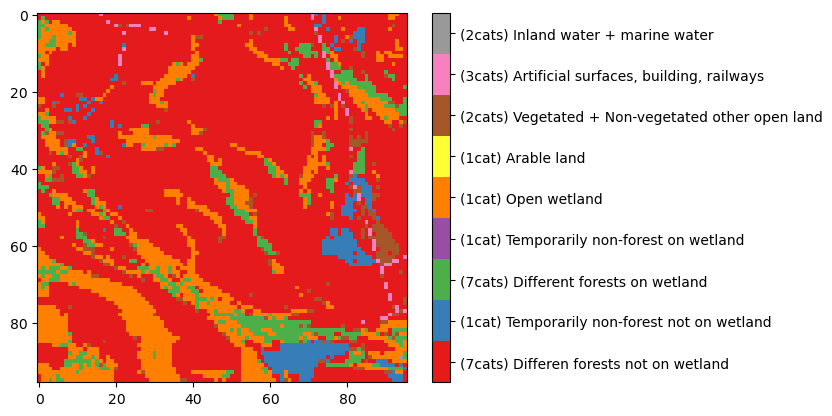

In [5]:
tick_labels = ['(7cats) Differen forests not on wetland',
               '(1cat) Temporarily non-forest not on wetland',
               '(7cats) Different forests on wetland',
               '(1cat) Temporarily non-forest on wetland',
               '(1cat) Open wetland',
               '(1cat) Arable land', 
               '(2cats) Vegetated + Non-vegetated other open land',
               '(3cats) Artificial surfaces, building, railways', 
               '(2cats) Inland water + marine water',
               #'Outside of mapping area'
               ]
plt.imshow(dataset[2111][1],cmap='Set1', vmin=0, vmax=8)
plt.clim(-0.5, 9 - 0.5)
cbar = plt.colorbar()
ticks = np.arange(9)
cbar.set_ticks(ticks ,labels = tick_labels)


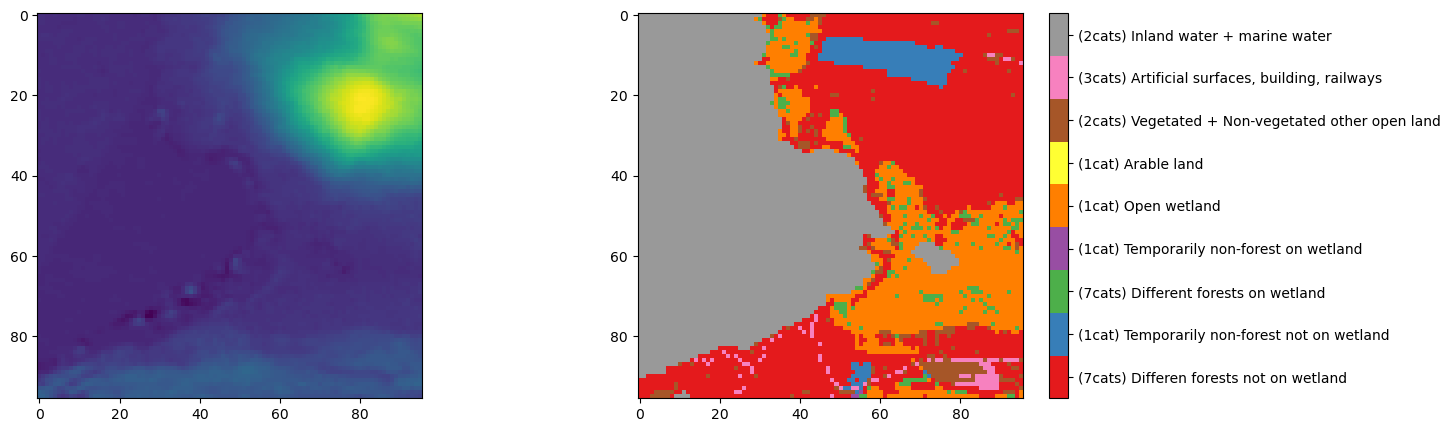

In [19]:
from matplotlib import colors
i = 7
fig, axes = plt.subplots( 1, 2, figsize=(15,5))
ax0 = axes[0].imshow(dataset[i][0][0]+1,norm=colors.LogNorm())
ax1 = axes[1].imshow(dataset[i][1],cmap='Set1', vmin=0, vmax=8)#,interpolation='nearest')
cbar = plt.colorbar(ax1)
ax1.set_clim(-0.5, 9 - 0.5)
ticks = np.arange(9)
cbar.set_ticks(ticks ,labels = tick_labels)



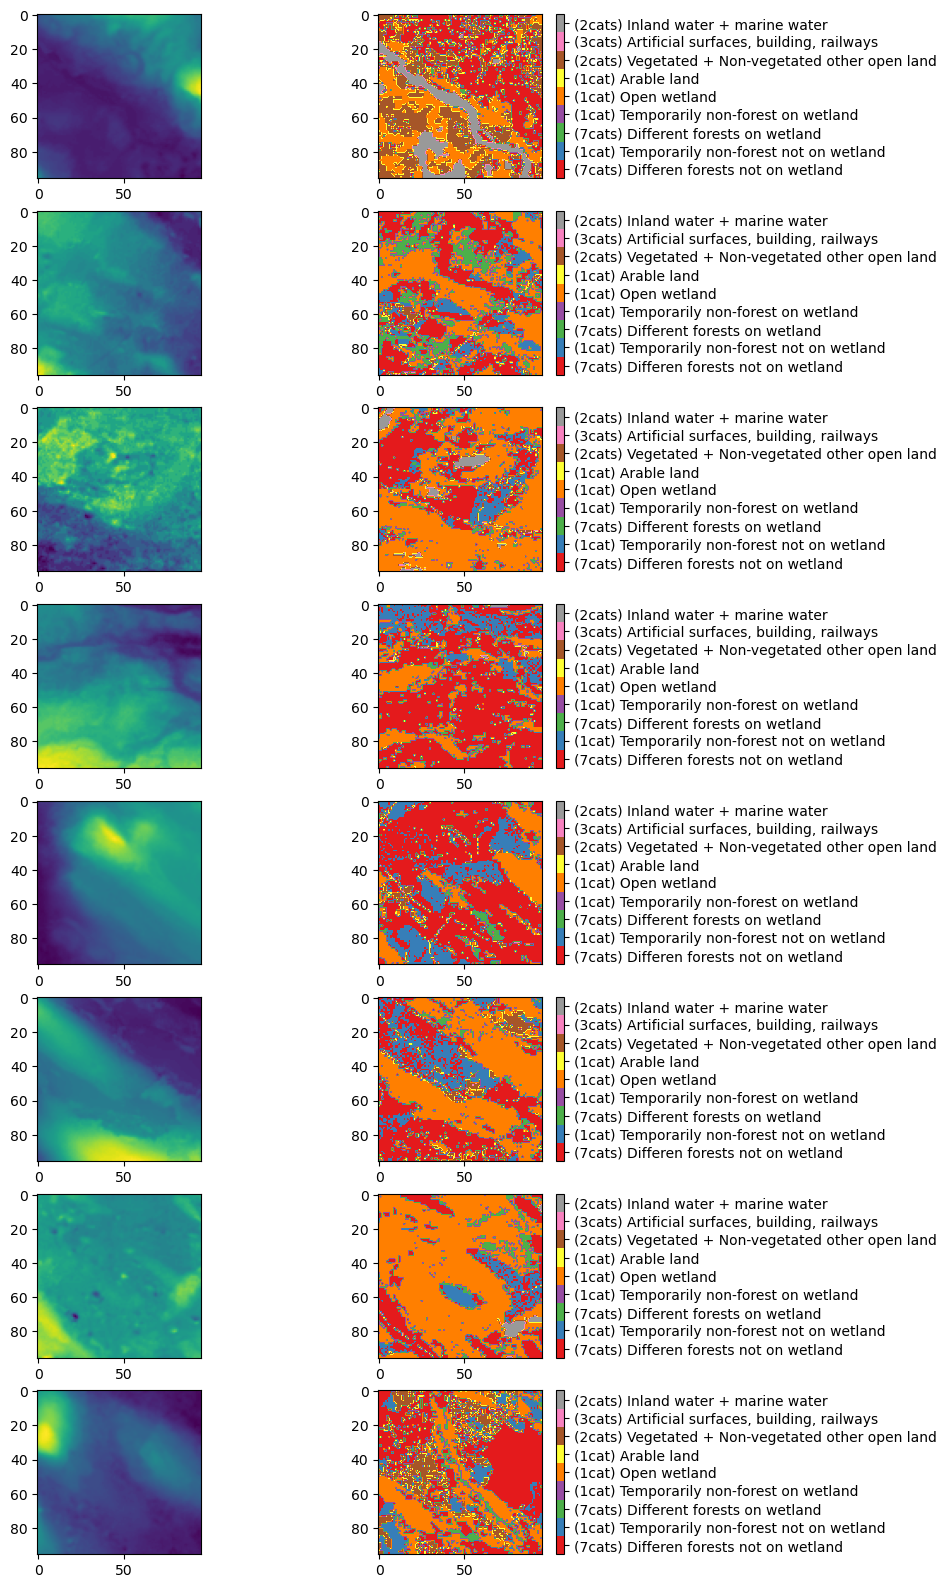

In [20]:
plot_range = 8
fig, axes = plt.subplots(plot_range, 2, figsize=(plot_range, plot_range*2.5))
for i in range(plot_range):
    ax0 = axes[i,0].imshow(dataset[0-i*100][0][0])
    ax1 = axes[i,1].imshow(dataset[0-i*100][1],cmap='Set1', vmin=0, vmax=8)
    cbar = plt.colorbar(ax1)
    ax1.set_clim(-0.5, 9 - 0.5)
    ticks = np.arange(9)
    cbar.set_ticks(ticks ,labels = tick_labels)


# Change of label

In [7]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

def apply_along_axis(function, x, axis,minlength: int = 0):
     return torch.stack([
                        function(x_i,minlength=minlength) for x_i in torch.unbind(x, dim=axis)
                        ], dim=axis)

In [8]:
apply_along_axis(torch.bincount,next(iter(train_dataloader))[1].flatten(start_dim=1), 0 ,minlength = 9)/9216

tensor([[3.4288e-01, 1.3780e-02, 7.9427e-02, 0.0000e+00, 4.8134e-01, 0.0000e+00,
         7.5412e-02, 6.4019e-03, 7.5955e-04],
        [3.3865e-01, 5.0022e-02, 2.5391e-02, 0.0000e+00, 5.3537e-01, 0.0000e+00,
         1.8989e-02, 2.3872e-03, 2.9188e-02],
        [5.2051e-01, 1.5191e-03, 1.6276e-02, 0.0000e+00, 2.2591e-01, 0.0000e+00,
         2.2407e-01, 4.8828e-03, 6.8359e-03],
        [3.6155e-01, 1.1664e-01, 5.9136e-02, 5.4253e-04, 4.1678e-01, 0.0000e+00,
         3.8737e-02, 4.0148e-03, 2.6042e-03],
        [2.5564e-01, 8.2248e-02, 3.4288e-02, 0.0000e+00, 3.5634e-01, 0.0000e+00,
         1.0547e-01, 8.1380e-03, 1.5788e-01],
        [3.9269e-01, 0.0000e+00, 1.3238e-02, 0.0000e+00, 4.5356e-01, 0.0000e+00,
         1.3043e-01, 0.0000e+00, 1.0091e-02],
        [3.5938e-01, 1.4985e-01, 2.2244e-02, 1.0851e-04, 3.1727e-01, 0.0000e+00,
         3.2552e-02, 5.7509e-03, 1.1285e-01],
        [5.2420e-01, 0.0000e+00, 5.0998e-03, 0.0000e+00, 5.6207e-02, 0.0000e+00,
         4.0408e-01, 0.0000e+0

# Model

# Use the torchvision's implementation of ResNeXt, but add FC layer for a different number of classes (27) and a Sigmoid instead of a default Softmax.
import torchvision
class Resnet18(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        #resnet = torchvision.models.resnext50_32x4d(pretrained=True)
        resnet = torchvision.models.resnet18()
        
        num_input_channel = 1
        resnet.conv1 = nn.Conv2d(num_input_channel, 64, kernel_size=7, stride=2, padding=3,bias=False)
        #resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()
 
    def forward(self, x):
        return self.sigm(self.base_model(x))
 
# Initialize the model
model = Resnet18(n_classes = 9)
# Switch model to the training mode
model.train()
model.to(device)

criterion = nn.BCELoss()

In [9]:
# Use the torchvision's implementation of ResNeXt, but add FC layer for a different number of classes (27) and a Sigmoid instead of a default Softmax.
import torchvision
class Resnet18(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        #resnet = torchvision.models.resnext50_32x4d(pretrained=True)
        resnet = torchvision.models.resnet18()
        
        num_input_channel = 1
        resnet.conv1 = nn.Conv2d(num_input_channel, 64, kernel_size=7, stride=2, padding=3,bias=False)
        #resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        
 
    def forward(self, x):
        return self.base_model(x)
 
# Initialize the model
model = Resnet18(n_classes = 9)
# Switch model to the training mode
model.train()
model.to(device)

Resnet18(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [10]:
criterion = torch.nn.BCEWithLogitsLoss()


max_epoch_number = 1000
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)
my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)
log_every = 50
test_every = 50
save_checkpoint = "SwedenData/checkpoints/Segmentation_distribution_normranged_normalized_smalldata_1000epoch_bcelogits_local_bc64.pth"



In [ ]:
import wandb
import random
import sklearn

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Segmentation_distribution_smalldata_crossentr",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "resnet18",
    "optimizer": "CELoss",
    "dataset": "Sweden_small",
    "epochs": max_epoch_number,
    }
)


In [11]:

from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score,explained_variance_score

epoch = 0
iteration = 0
model.train()
while True:
    batch_losses = []
    Y_list = []
    Y_pred_N_list = []

    for imgs, targets in train_dataloader:
        targets = apply_along_axis(torch.bincount,targets.flatten(start_dim=1), 0 ,minlength = 9)/9216
        imgs, targets = imgs.to(device), targets.to(device)
        optimizer.zero_grad()
 
        model_result = model(imgs)
        loss = criterion(model_result, targets.type(torch.float))
 
        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()
 
        batch_losses.append(batch_loss_value)
        wandb.log({'iteration_loss': loss.item()})
 
        iteration += 1

        if epoch % log_every==0:
            Y_list.append(targets)
            Y_pred_N_list.append(torch.sigmoid(model_result))

    
    my_lr_scheduler.step()
    current_lr = my_lr_scheduler.get_last_lr()[0]
    loss_value = np.mean(batch_losses)
    wandb.log({"epoch_loss": loss_value, "learning_rate": current_lr})



    if epoch % log_every==0:
        model_name = save_checkpoint
        torch.save(model.state_dict(), model_name)

        kl_div = F.kl_div(torch.vstack(Y_pred_N_list).log(), torch.vstack(Y_list), None, None, 'batchmean')
        wandb.log({"train_KL_divergence": kl_div})

        msle = []#(the best value is 0.0)
        mse = []#(the best value is 0.0)
        r2 = []#Best possible score is 1.0 and it can be negative
        evs = []#Best possible score is 1.0, lower values are worse.
        with torch.no_grad():
            for y_true,y_pred in zip(torch.vstack(Y_list).cpu().numpy(), torch.vstack(Y_pred_N_list).cpu().numpy()):
                msle.append(mean_squared_log_error(y_true, y_pred))
                mse.append(mean_squared_error(y_true, y_pred))
                r2.append(r2_score(y_true, y_pred))
                evs.append(explained_variance_score(y_true, y_pred))
            wandb.log({"train_mean_squared_log_error": np.mean(msle),
                      "train_mean_squared_error": np.mean(mse),
                      "train_r2_score": np.mean(r2),
                      "train_explained_variance_score": np.mean(evs)})



    if epoch % test_every==0:
        model.eval()

        Y_list = []
        Y_pred_N_list = []
        with torch.no_grad():
            for X,Y in train_dataloader:
                X, Y = X.to(device), Y.to(device)
                Y_pred_N = model(X)
                targets = apply_along_axis(torch.bincount,Y.flatten(start_dim=1), 0 ,minlength = 9)/9216
                Y_list.append(targets)
                Y_pred_N_list.append(torch.sigmoid(Y_pred_N))

        kl_div = F.kl_div(torch.vstack(Y_pred_N_list).log(), torch.vstack(Y_list), None, None, 'batchmean')
        wandb.log({"traineval_KL_divergence": kl_div})

        msle = []#(the best value is 0.0)
        mse = []#(the best value is 0.0)
        r2 = []#Best possible score is 1.0 and it can be negative
        evs = []#Best possible score is 1.0, lower values are worse.
        with torch.no_grad():
            for y_true,y_pred in zip(torch.vstack(Y_list).cpu().numpy(), torch.vstack(Y_pred_N_list).cpu().numpy()):
                msle.append(mean_squared_log_error(y_true, y_pred))
                mse.append(mean_squared_error(y_true, y_pred))
                r2.append(r2_score(y_true, y_pred))
                evs.append(explained_variance_score(y_true, y_pred))
            wandb.log({"traineval_mean_squared_log_error": np.mean(msle),
                      "traineval_mean_squared_error": np.mean(mse),
                      "traineval_r2_score": np.mean(r2),
                      "traineval_explained_variance_score": np.mean(evs)})


        Y_list = []
        Y_pred_N_list = []
        with torch.no_grad():
            for X,Y in train_dataloader:
                X, Y = X.to(device), Y.to(device)
                Y_pred_N = model(X)
                targets = apply_along_axis(torch.bincount,Y.flatten(start_dim=1), 0 ,minlength = 9)/9216
                Y_list.append(targets)
                Y_pred_N_list.append(torch.sigmoid(Y_pred_N))

        kl_div = F.kl_div(torch.vstack(Y_pred_N_list).log(), torch.vstack(Y_list), None, None, 'batchmean')
        wandb.log({"testeval_KL_divergence": kl_div})

        msle = []#(the best value is 0.0)
        mse = []#(the best value is 0.0)
        r2 = []#Best possible score is 1.0 and it can be negative
        evs = []#Best possible score is 1.0, lower values are worse.
        with torch.no_grad():
            for y_true,y_pred in zip(torch.vstack(Y_list).cpu().numpy(), torch.vstack(Y_pred_N_list).cpu().numpy()):
                msle.append(mean_squared_log_error(y_true, y_pred))
                mse.append(mean_squared_error(y_true, y_pred))
                r2.append(r2_score(y_true, y_pred))
                evs.append(explained_variance_score(y_true, y_pred))
            wandb.log({"testeval_mean_squared_log_error": np.mean(msle),
                      "testeval_mean_squared_error": np.mean(mse),
                      "testeval_r2_score": np.mean(r2),
                      "testeval_explained_variance_score": np.mean(evs)})


        model.train()



    epoch += 1
    if max_epoch_number < epoch:
        break



epoch: 0 iter: 65 train: loss:0.271
epoch: 1 iter:130 train: loss:0.254


# Evaluation

In [10]:
model_path = "SwedenData/checkpoints/Segmentation_distribution_normranged_normalized_smalldata_1000epoch_bcelogits_local_bc64.pth"
model = Resnet18(n_classes = 9).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

Resnet18(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [11]:
import torch.nn.functional as F

## Train dataset evaluation

In [62]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score,explained_variance_score

Y_list = []
Y_pred_N_list = []
with torch.no_grad():
    for X,Y in train_dataloader:
        X, Y = X.to(device), Y.to(device)
        Y_pred_N = model(X)
        targets = apply_along_axis(torch.bincount,Y.flatten(start_dim=1), 0 ,minlength = 9)/9216
        Y_list.append(targets)
        Y_pred_N_list.append(torch.sigmoid(Y_pred_N))

kl_div = F.kl_div(torch.vstack(Y_pred_N_list).log(), torch.vstack(Y_list), None, None, 'batchmean')

msle = []#(the best value is 0.0)
mse = []#(the best value is 0.0)
r2 = []#Best possible score is 1.0 and it can be negative
evs = []#Best possible score is 1.0, lower values are worse.
with torch.no_grad():
    for y_true,y_pred in zip(torch.vstack(Y_list).cpu().numpy(), torch.vstack(Y_pred_N_list).cpu().numpy()):
        msle.append(mean_squared_log_error(y_true, y_pred))
        mse.append(mean_squared_error(y_true, y_pred))
        r2.append(r2_score(y_true, y_pred))
        evs.append(explained_variance_score(y_true, y_pred))

print("KL divergence:", kl_div)
print("MSLE", np.mean(msle))
print("MSE", np.mean(mse))
print("r2 score", np.mean(r2))
print("evs score", np.mean(evs))


/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


KL divergence: tensor(0.33, device='cuda:0')
MSLE 0.005543291
MSE 0.009083571
r2 score 0.6997267350410858
evs score 0.7018244508548428


In [63]:
print(len(Y_list))
print(Y_list[0][0])
print(Y_pred_N_list[0][0])
print(Y_pred_N_list[0][0]/Y_list[0][0])

31
tensor([0.48, 0.11, 0.03, 0.00, 0.10, 0.00, 0.08, 0.03, 0.16], device='cuda:0')
tensor([    0.38,     0.04,     0.04,     0.00,     0.40,     0.00,     0.09,
            0.00,     0.03], device='cuda:0')
tensor([0.79, 0.35, 1.02,  inf, 3.86,  inf, 1.14, 0.18, 0.20], device='cuda:0')


In [64]:
r2_score(torch.vstack(Y_list)[:,0].cpu(), torch.vstack(Y_pred_N_list)[:,0].cpu())

-0.09907279332825714

In [65]:
explained_variance_score(torch.vstack(Y_list)[:,0].cpu(), torch.vstack(Y_pred_N_list)[:,0].cpu())

0.028914034366607666

In [66]:
#divide smaller by bigger
for i in range(9):
    class_ind = i
    result = []
    for true, pred in zip(torch.vstack(Y_list)[:,class_ind].cpu(), torch.vstack(Y_pred_N_list)[:,class_ind].cpu()):
        if true>=pred:
            res = pred/true
        else:
            res = true/pred
        result.append(res)
    print('class '+str(class_ind)+': '+ str(np.mean(result)))


class 0: 0.75049406
class 1: 0.29507077
class 2: 0.51312435
class 3: 0.16704018
class 4: 0.66565824
class 5: 0.002755925
class 6: 0.4406842
class 7: 0.34116557
class 8: 0.32242414


In [67]:
#divide pred by trues
for i in range(9):
    class_ind = i
    res = torch.vstack(Y_list)[:,class_ind].cpu()/torch.vstack(Y_pred_N_list)[:,class_ind].cpu()
    res[res>1] = 1
    print('class '+str(class_ind)+':'+ str(torch.mean(res)))

class 0:tensor(0.91)
class 1:tensor(0.66)
class 2:tensor(0.83)
class 3:tensor(0.33)
class 4:tensor(0.80)
class 5:tensor(0.05)
class 6:tensor(0.51)
class 7:tensor(0.56)
class 8:tensor(0.46)


In [13]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score,explained_variance_score

Y_list = []
Y_pred_N_list = []
with torch.no_grad():
    for X,Y in test_dataloader:
        X, Y = X.to(device), Y.to(device)
        Y_pred_N = model(X)
        targets = apply_along_axis(torch.bincount,Y.flatten(start_dim=1), 0 ,minlength = 9)/9216
        Y_list.append(targets)
        Y_pred_N_list.append(torch.sigmoid(Y_pred_N))

kl_div = F.kl_div(torch.vstack(Y_pred_N_list).log(), torch.vstack(Y_list), None, None, 'batchmean')

msle = []#(the best value is 0.0)
mse = []#(the best value is 0.0)
r2 = []#Best possible score is 1.0 and it can be negative
evs = []#Best possible score is 1.0, lower values are worse.
with torch.no_grad():
    for y_true,y_pred in zip(torch.vstack(Y_list).cpu().numpy(), torch.vstack(Y_pred_N_list).cpu().numpy()):
        msle.append(mean_squared_log_error(y_true, y_pred))
        mse.append(mean_squared_error(y_true, y_pred))
        r2.append(r2_score(y_true, y_pred))
        evs.append(explained_variance_score(y_true, y_pred))

print("KL divergence:", kl_div)
print("MSLE", np.mean(msle))
print("MSE", np.mean(mse))
print("r2 score", np.mean(r2))
print("evs score", np.mean(evs))

/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


KL divergence: tensor(0.3125, device='cuda:0')
MSLE 0.0051440313
MSE 0.0084271515
r2 score 0.7219663466141779
evs score 0.7240573117552802


In [20]:
torch.set_printoptions(sci_mode=False,precision=2)
print(len(Y_list))
print(Y_list[0][0])
print(Y_pred_N_list[0][0])
print(Y_pred_N_list[0][0]/Y_list[0][0])

6
tensor([    0.30,     0.01,     0.04,     0.00,     0.63,     0.00,     0.01,
            0.00,     0.01], device='cuda:0')
tensor([    0.39,     0.02,     0.02,     0.00,     0.26,     0.00,     0.19,
            0.00,     0.05], device='cuda:0')
tensor([ 1.29,  3.91,  0.55,  0.19,  0.42,   inf, 16.56,   inf,  3.95],
       device='cuda:0')


In [60]:
r2_score(torch.vstack(Y_list)[:,0].cpu(), torch.vstack(Y_pred_N_list)[:,0].cpu())

-0.11411189967808544

In [61]:
explained_variance_score(torch.vstack(Y_list)[:,0].cpu(), torch.vstack(Y_pred_N_list)[:,0].cpu())

0.023947596549987793

In [59]:
#divide smaller by bigger
for i in range(9):
    class_ind = i
    result = []
    for true, pred in zip(torch.vstack(Y_list)[:,class_ind].cpu(), torch.vstack(Y_pred_N_list)[:,class_ind].cpu()):
        if true>=pred:
            res = pred/true
        else:
            res = true/pred
        result.append(res)
    print('class '+str(class_ind)+': '+ str(np.mean(result)))


class 0: 0.7574525
class 1: 0.3140595
class 2: 0.52655464
class 3: 0.17447828
class 4: 0.6706354
class 5: 0.0024542809
class 6: 0.4503574
class 7: 0.3538125
class 8: 0.3269172


In [55]:
#divide pred by trues
for i in range(9):
    class_ind = i
    res = torch.vstack(Y_list)[:,class_ind].cpu()/torch.vstack(Y_pred_N_list)[:,class_ind].cpu()
    res[res>1] = 1
    print('class '+str(class_ind)+':'+ str(torch.mean(res)))

class 0:tensor(0.91)
class 1:tensor(0.67)
class 2:tensor(0.83)
class 3:tensor(0.38)
class 4:tensor(0.81)
class 5:tensor(0.04)
class 6:tensor(0.52)
class 7:tensor(0.57)
class 8:tensor(0.47)


# Comparison to other distributions

tensor([[0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111]])
KL divergence is:  tensor(0.9848)


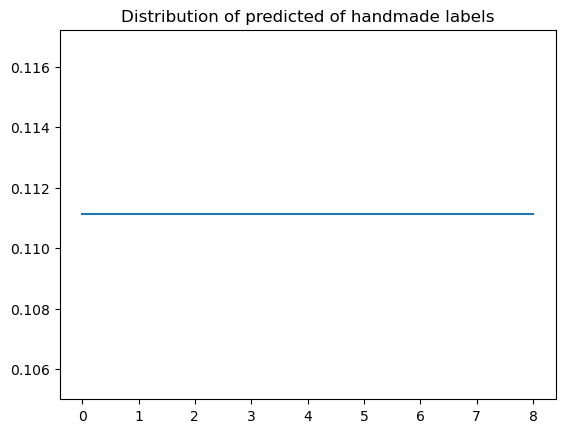

In [39]:
# Evaluating with uniform distribution

uniform_distr = (torch.ones(1,9)/9)
plt.plot(uniform_distr[0])
plt.title('Distribution of predicted of handmade labels')
print(uniform_distr)

kl_div_list = []
with torch.no_grad():
    for X,Y in train_dataset:
        X, Y = X.to(device), Y
        targets = torch.bincount(Y.flatten(), minlength = 9)/9216
        uniform_distr = (torch.ones(1,9)/9)
        
        kl_div = F.kl_div(uniform_distr.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)
print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(train_dataset))

tensor([[0.1257, 0.0766, 0.1495, 0.0186, 0.0080, 0.0940, 0.1805, 0.2176, 0.1294]])
KL divergence is:  tensor(1.2621)


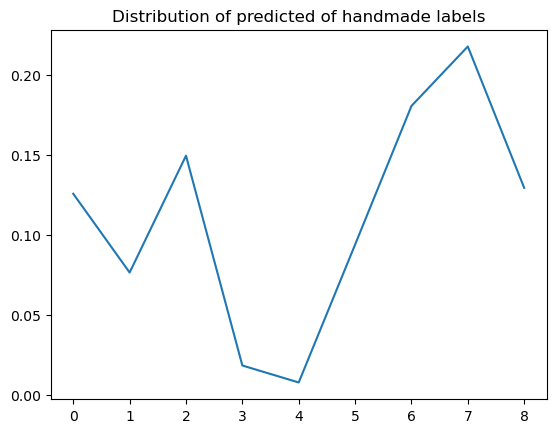

In [40]:
# Evaluating with random distribution

rand_tens = torch.rand(1,9)
rand_distr = rand_tens/torch.sum(rand_tens)
plt.plot(rand_distr[0])
plt.title('Distribution of predicted of handmade labels')
print(rand_distr)

kl_div_list = []
with torch.no_grad():
    for X,Y in train_dataset:
        X, Y = X.to(device), Y
        targets = torch.bincount(Y.flatten(), minlength = 9)/9216
        rand_tens = torch.rand(1,9)
        rand_distr = rand_tens/torch.sum(rand_tens)
        
        kl_div = F.kl_div(rand_distr.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)
print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(train_dataset))

tensor([0.1889, 0.1713, 0.1601, 0.1168, 0.1185, 0.0822, 0.0742, 0.0566, 0.0315])
KL divergence is:  tensor(0.8218)


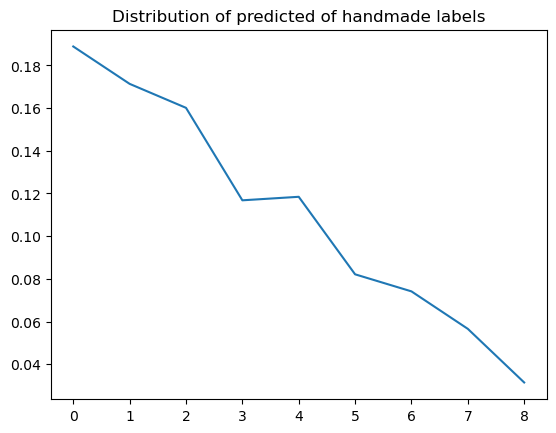

In [35]:
#Evaluating with slope distribution

slope_distr = torch.normal(mean=torch.arange(10., 1., -1.), std=torch.arange(1, 0.1, -0.1))
slope_distr = slope_distr/torch.sum(slope_distr)
plt.plot(slope_distr)
plt.title('Distribution of predicted of handmade labels')
print(slope_distr)

kl_div_list = []
with torch.no_grad():
    for X,Y in train_dataset:
        X, Y = X.to(device), Y
        targets = torch.bincount(Y.flatten(), minlength = 9)/9216
        slope_distr = torch.normal(mean=torch.arange(10., 1., -1.), std=torch.arange(1, 0.1, -0.1))
        slope_distr = slope_distr/torch.sum(slope_distr)
        
        kl_div = F.kl_div(slope_distr.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)
print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(train_dataset))

tensor([0.1635, 0.1459, 0.1550, 0.1494, 0.1267, 0.0974, 0.0757, 0.0502, 0.0362])
KL divergence is:  tensor(0.8190)


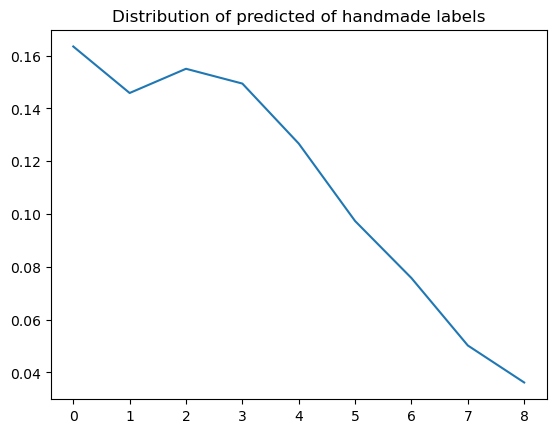

In [34]:
#Evaluating with slope distribution

slope_distr = torch.normal(mean=torch.arange(10., 1., -1.), std=torch.arange(1, 0.1, -0.1))
slope_distr = slope_distr/torch.sum(slope_distr)
plt.plot(slope_distr)
plt.title('Distribution of predicted of handmade labels')
print(slope_distr)

kl_div_list = []
with torch.no_grad():
    for X,Y in train_dataset:
        X, Y = X.to(device), Y
        targets = torch.bincount(Y.flatten(), minlength = 9)/9216
        slope_distr = torch.normal(mean=torch.arange(10., 1., -1.), std=torch.arange(1, 0.1, -0.1))
        slope_distr = slope_distr/torch.sum(slope_distr)
        
        kl_div = F.kl_div(slope_distr.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)
print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(train_dataset))

## Test dataset evaluation

In [256]:
model.eval()
print(len(test_dataloader))
kl_div_list = []

with torch.no_grad():
    for X,Y in test_dataloader:
        X, Y = X.to(device), Y.to(device)
        Y_pred_N = model(X)
        targets = apply_along_axis(torch.bincount,Y.flatten(start_dim=1), 0 ,minlength = 9)/9216
        
        kl_div = F.kl_div(Y_pred_N.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)

print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(test_dataset))

8
KL divergence is:  tensor(0.1779, device='cuda:0')


tensor([[0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111]])
KL divergence is:  tensor(0.8755)


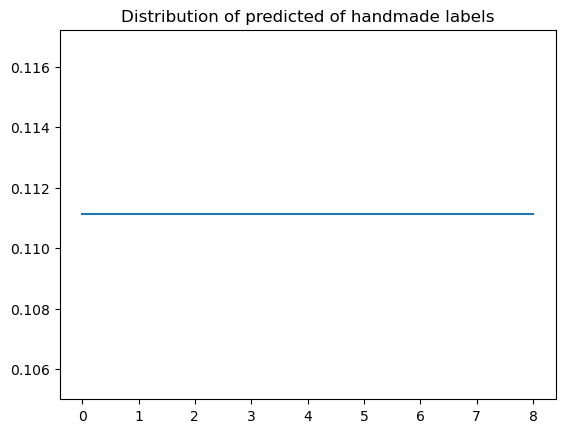

In [274]:
# Evaluating with uniform distribution

uniform_distr = (torch.ones(1,9)/9)
plt.plot(uniform_distr[0])
plt.title('Distribution of predicted of handmade labels')
print(uniform_distr)

kl_div_list = []
with torch.no_grad():
    for X,Y in test_dataloader:
        X, Y = X.to(device), Y
        targets = apply_along_axis(torch.bincount,Y.flatten(start_dim=1), 0 ,minlength = 9)/9216
        uniform_distr = (torch.ones(len(Y),9)/9)
        
        kl_div = F.kl_div(uniform_distr.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)
print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(test_dataset))

tensor([[0.0008, 0.0687, 0.1685, 0.2094, 0.0098, 0.1934, 0.1115, 0.1706, 0.0672]])
KL divergence is:  tensor(1.2375)


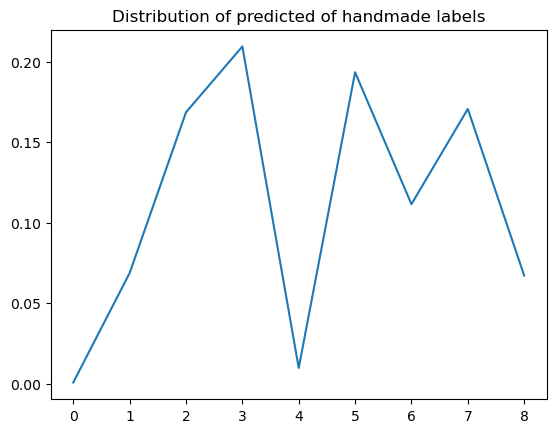

In [273]:
# Evaluating with random distribution

rand_tens = torch.rand(1,9)
rand_distr = rand_tens/torch.sum(rand_tens)
plt.plot(rand_distr[0])
plt.title('Distribution of predicted of handmade labels')
print(rand_distr)

kl_div_list = []
with torch.no_grad():
    for X,Y in test_dataloader:
        X, Y = X.to(device), Y
        targets = apply_along_axis(torch.bincount,Y.flatten(start_dim=1), 0 ,minlength = 9)/9216
        rand_tens = torch.rand(1,9)
        rand_distr = rand_tens/torch.sum(rand_tens)
        
        kl_div = F.kl_div(rand_distr.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)
print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(test_dataset))

tensor([0.1761, 0.1713, 0.1678, 0.1435, 0.1015, 0.0855, 0.0690, 0.0472, 0.0381])
KL divergence is:  tensor(0.6701)


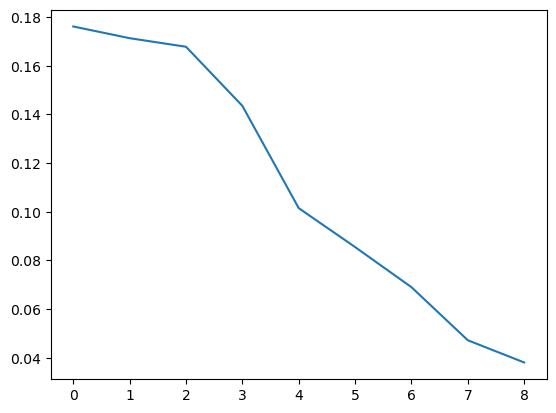

In [266]:
#Evaluating with slope distribution

slope_distr = torch.normal(mean=torch.arange(10., 1., -1.), std=torch.arange(1, 0.1, -0.1))
slope_distr = slope_distr/torch.sum(slope_distr)
plt.plot(slope_distr)
plt.title('Distribution of predicted of handmade labels')
print(slope_distr)

kl_div_list = []
with torch.no_grad():
    for X,Y in test_dataloader:
        X, Y = X.to(device), Y
        targets = apply_along_axis(torch.bincount,Y.flatten(start_dim=1), 0 ,minlength = 9)/9216
        slope_distr = torch.normal(mean=torch.arange(10., 1., -1.), std=torch.arange(1, 0.1, -0.1))
        slope_distr = slope_distr/torch.sum(slope_distr)
        
        kl_div = F.kl_div(slope_distr.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)
print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(test_dataset))

tensor([    0.8333,     0.1389,     0.0231,     0.0039,     0.0006,     0.0001,
            0.0000,     0.0000,     0.0000])
KL divergence is:  tensor(2.5397)


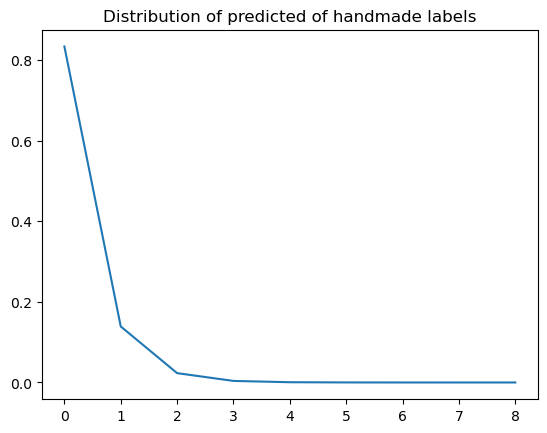

In [268]:
#Evaluating with slope distribution

exp = torch.arange(10., 1.,-1)
base = 6
torch.pow(base, exp)
slope_distr = torch.pow(base, exp)
slope_distr = slope_distr/torch.sum(slope_distr)
plt.plot(slope_distr)
plt.title('Distribution of predicted of handmade labels')
print(slope_distr)

kl_div_list = []
with torch.no_grad():
    for X,Y in test_dataloader:
        X, Y = X.to(device), Y
        targets = apply_along_axis(torch.bincount,Y.flatten(start_dim=1), 0 ,minlength = 9)/9216
        exp = torch.arange(10., 1.,-1)
        base = 6
        torch.pow(base, exp)
        slope_distr = torch.pow(base, exp)
        slope_distr = slope_distr/torch.sum(slope_distr)
        
        kl_div = F.kl_div(slope_distr.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)
print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(test_dataset))